## Set up the input pipeline

In [ ]:
!pip install git+https://github.com/tensorflow/examples.git

  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-h4h580e_
  Running command git clone -q https://github.com/tensorflow/examples.git /tmp/pip-req-build-h4h580e_
  Created wheel for tensorflow-examples: filename=tensorflow_examples-a751758c2ea744412fb366e14c99901a983f6127_-py3-none-any.whl size=270923 sha256=c11fc9328780f9c3274d22f6583ff02ae312ed805b9a11da94404cea715ca61e
  Stored in directory: /tmp/pip-ephem-wheel-cache-cn2prdan/wheels/eb/19/50/2a4363c831fa12b400af86325a6f26ade5d2cdc5b406d552ca
Failed to build tensorflow-examples
    Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel could not be built for it. A possible replacement is to fix the wheel build issue reported above. You can find discussion regarding this at https://github.com/pypa/pip/issues/8368.


In [ ]:
import tensorflow as tf

In [ ]:
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix

import os
import time
import matplotlib.pyplot as plt
import PIL
import numpy as np
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE


* In random jittering, the image is resized to `286 x 286` and then randomly cropped to `256 x 256`.
* In random mirroring, the image is randomly flipped horizontally i.e left to right.

In [ ]:
dataset, metadata = tfds.load('cycle_gan/monet2photo',with_info=True, as_supervised=True)

train_monets, train_photos = dataset['trainA'], dataset['trainB']
test_monets, test_photos = dataset['testA'], dataset['testB']

Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteCKGA6H/cycle_gan-trainA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteCKGA6H/cycle_gan-trainB.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteCKGA6H/cycle_gan-testA.tfrecord


Shuffling and writing examples to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0.incompleteCKGA6H/cycle_gan-testB.tfrecord


Dataset cycle_gan downloaded and prepared to /root/tensorflow_datasets/cycle_gan/monet2photo/2.0.0. Subsequent calls will reuse this data.


In [ ]:
BUFFER_SIZE = 1000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
def random_crop(image):
  cropped_image = tf.image.random_crop(
      image, size=[IMG_HEIGHT, IMG_WIDTH, 3])

  return cropped_image

In [ ]:
# normalizing the images to [-1, 1]
def normalize(image):
  image = tf.cast(image, tf.float32)
  image = (image / 127.5) - 1
  return image

In [ ]:
def random_jitter(image):
  # resizing to 286 x 286 x 3
  image = tf.image.resize(image, [286, 286],
                          method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)

  # randomly cropping to 256 x 256 x 3
  image = random_crop(image)

  # random mirroring
  image = tf.image.random_flip_left_right(image)

  return image

In [ ]:
def preprocess_image_train(image, label):
  image = random_jitter(image)
  image = normalize(image)
  return image

In [ ]:
def preprocess_image_test(image, label):
  image = normalize(image)
  return image

In [ ]:
train_monets = train_monets.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

train_photos = train_photos.cache().map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_monets = test_monets.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

test_photos = test_photos.map(
    preprocess_image_test, num_parallel_calls=AUTOTUNE).cache().shuffle(
    BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
sample_monet = next(iter(train_monets))
sample_photo = next(iter(train_photos))

## Generator and Discriminator

There are 2 generators (G and F) and 2 discriminators (X and Y) being trained here. 

* Generator `G` learns to transform image `X` to image `Y`. $(G: X -> Y)$
* Generator `F` learns to transform image `Y` to image `X`. $(F: Y -> X)$
* Discriminator `D_X` learns to differentiate between image `X` and generated image `X` (`F(Y)`).
* Discriminator `D_Y` learns to differentiate between image `Y` and generated image `Y` (`G(X)`).

![Cyclegan model](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/generative/images/cyclegan_model.png?raw=1)

In [ ]:
class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset


def downsample(filters, size, norm_type='batchnorm', apply_norm=True):
  """Downsamples an input.
  Conv2D => Batchnorm => LeakyRelu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_norm: If True, adds the batchnorm layer
  Returns:
    Downsample Sequential Model
  """
  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

  if apply_norm:
    if norm_type.lower() == 'batchnorm':
      result.add(tf.keras.layers.BatchNormalization())
    elif norm_type.lower() == 'instancenorm':
      result.add(InstanceNormalization())

  result.add(tf.keras.layers.LeakyReLU())

  return result


def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result


def unet_generator(output_channels, norm_type='batchnorm'):
  """Modified u-net generator model (https://arxiv.org/abs/1611.07004).
  Args:
    output_channels: Output channels
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
  Returns:
    Generator model
  """

  down_stack = [
      downsample(64, 4, norm_type, apply_norm=False),  # (bs, 128, 128, 64)
      downsample(128, 4, norm_type),  # (bs, 64, 64, 128)
      downsample(256, 4, norm_type),  # (bs, 32, 32, 256)
      downsample(512, 4, norm_type),  # (bs, 16, 16, 512)
      downsample(512, 4, norm_type),  # (bs, 8, 8, 512)
      downsample(512, 4, norm_type),  # (bs, 4, 4, 512)
      downsample(512, 4, norm_type),  # (bs, 2, 2, 512)
      downsample(512, 4, norm_type),  # (bs, 1, 1, 512)
  ]

  up_stack = [
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 2, 2, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 4, 4, 1024)
      upsample(512, 4, norm_type, apply_dropout=True),  # (bs, 8, 8, 1024)
      upsample(512, 4, norm_type),  # (bs, 16, 16, 1024)
      upsample(256, 4, norm_type),  # (bs, 32, 32, 512)
      upsample(128, 4, norm_type),  # (bs, 64, 64, 256)
      upsample(64, 4, norm_type),  # (bs, 128, 128, 128)
  ]

  initializer = tf.random_normal_initializer(0., 0.02)
  last = tf.keras.layers.Conv2DTranspose(
      output_channels, 4, strides=2,
      padding='same', kernel_initializer=initializer,
      activation='tanh')  # (bs, 256, 256, 3)

  concat = tf.keras.layers.Concatenate()

  inputs = tf.keras.layers.Input(shape=[None, None, 3])
  x = inputs

  # Downsampling through the model
  skips = []
  for down in down_stack:
    x = down(x)
    skips.append(x)

  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    x = concat([x, skip])

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

def discriminator(norm_type='instancenorm', target=True):
  """PatchGan discriminator model (https://arxiv.org/abs/1611.07004).
  Args:
    norm_type: Type of normalization. Either 'batchnorm' or 'instancenorm'.
    target: Bool, indicating whether target image is an input or not.
  Returns:
    Discriminator model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  inp = tf.keras.layers.Input(shape=[None, None, 3], name='input_image')
  x = inp

  if target:
    tar = tf.keras.layers.Input(shape=[None, None, 3], name='target_image')
    x = tf.keras.layers.concatenate([inp, tar])  # (bs, 256, 256, channels*2)

  down1 = downsample(64, 4, norm_type, False)(x)  # (bs, 128, 128, 64)
  down2 = downsample(128, 4, norm_type)(down1)  # (bs, 64, 64, 128)
  down3 = downsample(256, 4, norm_type)(down2)  # (bs, 32, 32, 256)

  zero_pad1 = tf.keras.layers.ZeroPadding2D()(down3)  # (bs, 34, 34, 256)
  conv = tf.keras.layers.Conv2D(
      512, 4, strides=1, kernel_initializer=initializer,
      use_bias=False)(zero_pad1)  # (bs, 31, 31, 512)

  if norm_type.lower() == 'batchnorm':
    norm1 = tf.keras.layers.BatchNormalization()(conv)
  elif norm_type.lower() == 'instancenorm':
    norm1 = InstanceNormalization()(conv)

  leaky_relu = tf.keras.layers.LeakyReLU()(norm1)

  zero_pad2 = tf.keras.layers.ZeroPadding2D()(leaky_relu)  # (bs, 33, 33, 512)

  last = tf.keras.layers.Conv2D(
      1, 4, strides=1,
      kernel_initializer=initializer)(zero_pad2)  # (bs, 30, 30, 1)

  if target:
    return tf.keras.Model(inputs=[inp, tar], outputs=last)
  else:
    return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
OUTPUT_CHANNELS = 3

# generator_g = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
# generator_f = unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

# discriminator_x = discriminator(norm_type='instancenorm', target=False)
# discriminator_y = discriminator(norm_type='instancenorm', target=False)

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

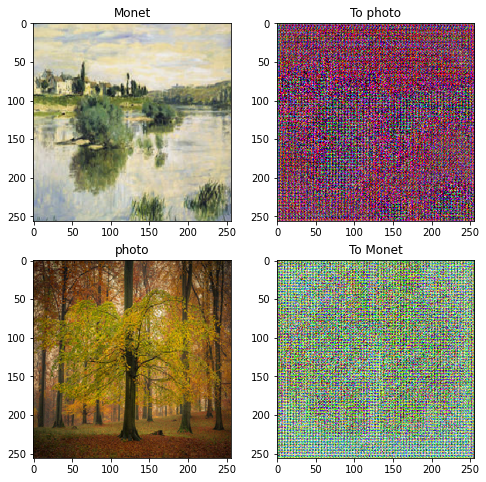

In [ ]:
to_photo = generator_g(sample_monet)
to_monet = generator_f(sample_photo)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sample_monet, to_photo, sample_photo, to_monet]
title = ['Monet', 'To photo', 'photo', 'To Monet']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

## Loss functions

In CycleGAN, there is no paired data to train on, hence there is no guarantee that the input `x` and the target `y` pair are meaningful during training. Thus in order to enforce that the network learns the correct mapping, the authors propose the cycle consistency loss.

In [ ]:
LAMBDA = 10

In [ ]:
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [ ]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [ ]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

As shown above, generator $G$ is responsible for translating image $X$ to image $Y$. Identity loss says that, if you fed image $Y$ to generator $G$, it should yield the real image $Y$ or something close to image $Y$.

If you run the zebra-to-horse model on a horse or the horse-to-zebra model on a zebra, it should not modify the image much since the image already contains the target class.

$$Identity\ loss = |G(Y) - Y| + |F(X) - X|$$

In [ ]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

Initialize the optimizers for all the generators and the discriminators.

In [ ]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Training

Even though the training loop looks complicated, it consists of four basic steps:

* Get the predictions.
* Calculate the loss.
* Calculate the gradients using backpropagation.
* Apply the gradients to the optimizer.

In [ ]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    
    
    # Total generator loss = adversarial loss
    total_gen_g_loss = gen_g_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)
  
  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)
  
  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
  return total_gen_g_loss, total_gen_f_loss, disc_x_loss, disc_y_loss

In [ ]:
EPOCHS = 12
to_photo_pred = np.zeros((EPOCHS+1,256,256,3))
to_monet_pred = np.zeros((EPOCHS+1,256,256,3))
to_photo_pred[0] = generator_g(sample_monet)
to_monet_pred[0] = generator_f(sample_photo)
geng_loss = np.zeros((EPOCHS,1))
genf_loss = np.zeros((EPOCHS,1))
discx_loss = np.zeros((EPOCHS,1))
discy_loss = np.zeros((EPOCHS,1))
for epoch in range(EPOCHS):
  start = time.time()

  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_monets, train_photos)):
    [geng_loss[epoch], genf_loss[epoch], discx_loss[epoch], discy_loss[epoch]] = train_step(image_x, image_y)
    if n % 10 == 0:
      print ('.', end='')
    n += 1
    if n == len(train_monets):
      print ("G_Loss = {}, F_Loss = {}, D_X_Loss = {}, D_Y_Loss = {}".format(geng_loss[epoch], genf_loss[epoch], discx_loss[epoch], discy_loss[epoch]))
  # clear_output(wait=True)
  # Using a consistent image (sample_horse) so that the progress of the model
  # is clearly visible.
  to_photo_pred[epoch+1] = generator_g(sample_monet)
  to_monet_pred[epoch+1] = generator_f(sample_photo)
  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,time.time()-start))

............................................................................................................G_Loss = [1.17601275], F_Loss = [0.99250108], D_X_Loss = [0.75760186], D_Y_Loss = [0.69937122]
Time taken for epoch 1 is 347.3348870277405 sec

............................................................................................................G_Loss = [1.63210702], F_Loss = [0.65336132], D_X_Loss = [0.82006937], D_Y_Loss = [0.88188189]
Time taken for epoch 2 is 337.28971338272095 sec

............................................................................................................G_Loss = [0.80584496], F_Loss = [1.47118485], D_X_Loss = [0.76469922], D_Y_Loss = [0.72305751]
Time taken for epoch 3 is 337.34497117996216 sec

............................................................................................................G_Loss = [1.21597946], F_Loss = [1.18366373], D_X_Loss = [0.55202162], D_Y_Loss = [0.49051052]
Time taken for epoch 4 is 382.009515285

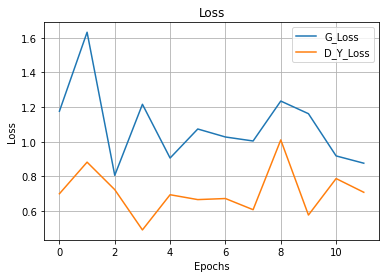

In [ ]:
fig = plt.figure()
plt.plot(geng_loss)
plt.plot(discy_loss)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['G_Loss', 'D_Y_Loss'], loc='upper right')
plt.grid()
plt.show()

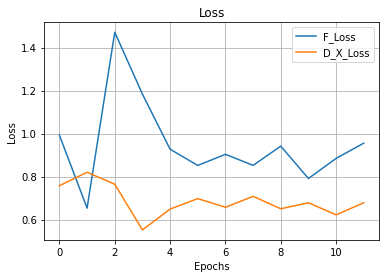

In [ ]:
fig = plt.figure()
plt.plot(genf_loss)
plt.plot(discx_loss)
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['F_Loss', 'D_X_Loss'], loc='upper right')
plt.grid()
plt.show()

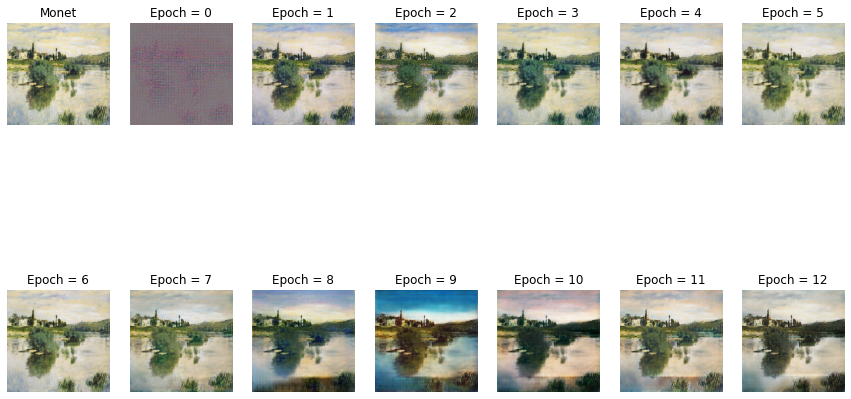

In [ ]:
plt.figure(figsize=(15,9))
plt.subplot(2,7,1, frameon=False)
plt.imshow(sample_monet[0] * 0.5 + 0.5)
plt.title('Monet')
plt.axis('off')
for epochs in range(EPOCHS+1):
  plt.subplot(2,7,epochs+2, frameon=False)
  plt.imshow(to_photo_pred[epochs] * 0.5 + 0.5)
  plt.title('Epoch = {epochs}'.format(epochs=epochs))
  plt.axis('off')
plt.show()  

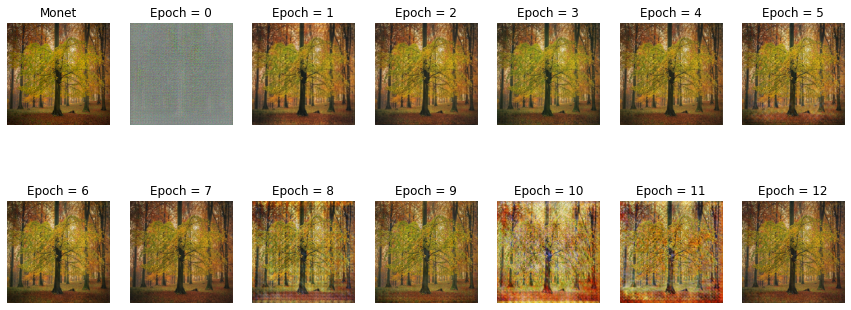

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(2,7,1, frameon=False)
plt.imshow(sample_photo[0] * 0.5 + 0.5)
plt.title('Monet')
plt.axis('off')
for epochs in range(EPOCHS+1):
  plt.subplot(2,7,epochs+2, frameon=False)
  plt.imshow(to_monet_pred[epochs] * 0.5 + 0.5)
  plt.title('Epoch = {epochs}'.format(epochs=epochs))
  plt.axis('off')
plt.show() 

(-0.5, 255.5, 255.5, -0.5)

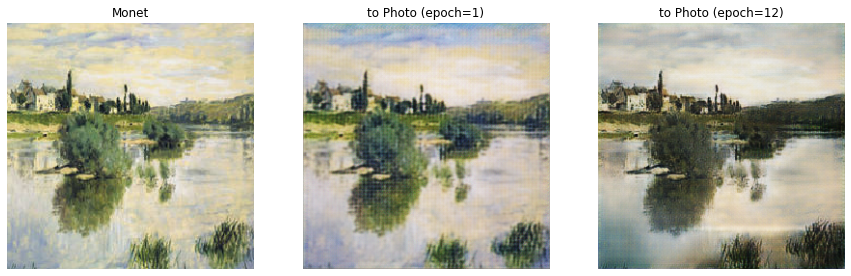

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1, frameon=False)
plt.imshow(sample_monet[0] * 0.5 + 0.5)
plt.title('Monet')
plt.axis('off')
plt.subplot(1,3,2, frameon=False)
plt.imshow(to_photo_pred[1] * 0.5 + 0.5)
plt.title('to Photo (epoch=1)')
plt.axis('off')
plt.subplot(1,3,3, frameon=False)
plt.imshow(to_photo_pred[EPOCHS] * 0.5 + 0.5)
plt.title('to Photo (epoch=12)')
plt.axis('off')

(-0.5, 255.5, 255.5, -0.5)

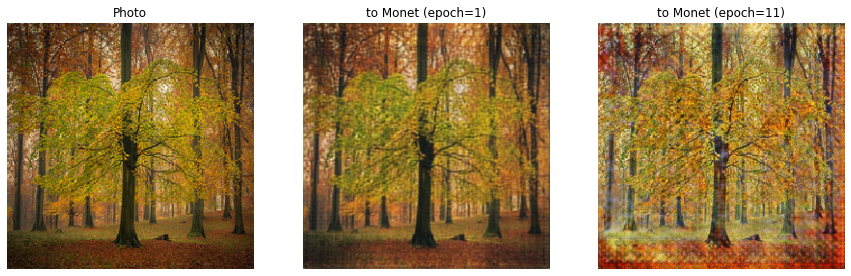

In [ ]:
plt.figure(figsize=(15,6))
plt.subplot(1,3,1, frameon=False)
plt.imshow(sample_photo[0] * 0.5 + 0.5)
plt.title('Photo')
plt.axis('off')
plt.subplot(1,3,2, frameon=False)
plt.imshow(to_monet_pred[1] * 0.5 + 0.5)
plt.title('to Monet (epoch=1)')
plt.axis('off')
plt.subplot(1,3,3, frameon=False)
plt.imshow(to_monet_pred[11] * 0.5 + 0.5)
plt.title('to Monet (epoch=11)')
plt.axis('off')

## Generate using test dataset

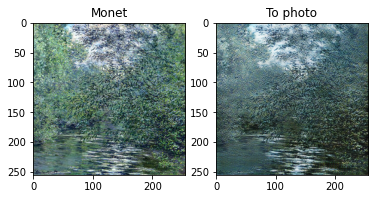

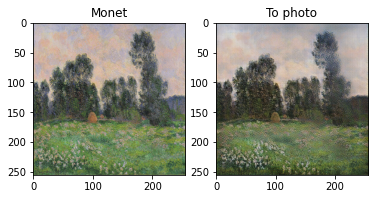

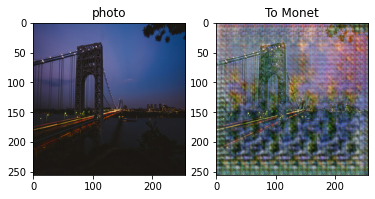

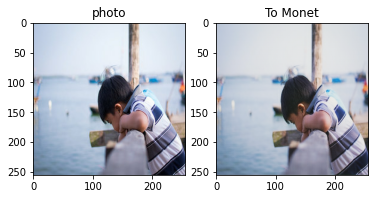

In [ ]:
# Run the trained model on the test dataset
for inp in test_monets.take(2):
  to_photo = generator_g(inp)
  imgs = [inp, to_photo]
  title = ['Monet', 'To photo']

  for i in range(len(imgs)):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  plt.show()

for inp in test_photos.take(2):
  to_monet = generator_f(inp)
  imgs = [inp, to_monet]
  title = ['photo', 'To Monet']

  for i in range(len(imgs)):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  plt.show()